For exploration of the cfbp complaints data.

To beign with we  have been provided with a dataset of over 350,000 such complaints for 5 common issue types. 
**Our goal is to train a text classification model to identify the issue type based on the consumer complaint narrative.**
The data can be downloaded from https://drive.google.com/file/d/1Hz1gnCCr-SDGjnKgcPbg7Nd3NztOLdxw/view?usp=share_link

This is a subset of a larger dataset which has 20 more common issues https://drive.google.com/file/d/1gW6LScUL-Z7mH6gUZn-1aNzm4p4CvtpL/view?usp=share_link.

Objective is to find a model to that can do the most predictions in right bucket.


In [85]:
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse.linalg import svds

from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize


from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')


In [39]:
reviews = pd.read_csv('../data/complaints.csv').dropna().reset_index(drop = True)
reviews.head()
reviews.shape #(353432, 2)

(353432, 2)

In [40]:
#How many complaints per issue
reviews['Issue'].value_counts()
# reviews['Issue'].value_counts().plot(kind='bar');

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: Issue, dtype: int64

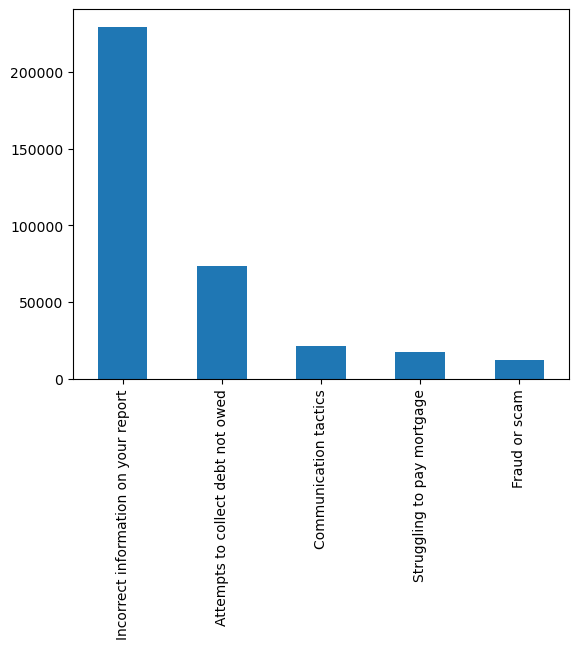

In [41]:
reviews['Issue'].value_counts().plot(kind='bar');

#create a sentiemnt column based on the issues.
This is a multiclass classification problem we will have to follow that path we can not have the sentiement column.

In [42]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Incorrect information on your report", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

I just reviewed a copy of my Experian credit report and found the following information to be an error. I am a victim of identity theft and did not make these charges. I reported the theft of my identity to the Federal Trade Commission.
-----------------------------
after my legal separation from my husband he started to open credit in my name with no permission I have a legal case against him but can not find him he has ruined my life his name is XXXX XXXX XXXX   remove I have disputed by mail with all three credit bureaus. act # XXXX owing an alleged {$2200.00} XXXX   XXXX  orig creditor XXXX
-----------------------------
Equifax report a collections account " XXXX XXXX XXXX ''. I have no knowledge of this account. I have not been furnished any proof or verifications of this account. I don't have any signed contract agreements with XXXX XXXX XXXX, verbal agreements nor any paperwork associated with them. A proper investigation according to FCRA was not conducted, word of mouth from t

In [43]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Attempts to collect debt not owed", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

This company in which I hold no contract with nor have received services from reported ( 3 ) different collection accounts against my Social Security Number in the amount of {$510.00}, {$710.00} and {$570.00} with XXXX, XXXX & XXXX   credit reporting agencies. I requested verification and validation on XX/XX/2018 of the alleged debt and account, however, the business failed to provide adequate proof. Considering this business does not have a contract with me for goods or services they have provided nor have they provided adequate proof, I am not obligated to pay for the alleged debt.
-----------------------------
An affidavit of Billing Error Notice was mailed to XXXX XXXX XXXX XXXX and/or XXXX, XXXX but they didn't respond back. 

The account is an agreement, not a contract. Based on the consumer protection laws and your lack of complete disclosure I rescind the entire transaction due to fraud. 

CONSUMER PROTECTION LAWS and U.S. CODE VIOLATIONS : Equal Credit Opportunity Act / Truth 

In [44]:
seed = 123
for statement in reviews.loc[reviews['Issue'] == "Fraud or scam", 'Consumer complaint narrative'].sample(3, random_state=seed):
    print(statement)
    print('-----------------------------')

I am disputing Wells Fargos response ( Wells Fargo case # : XXXX ). Please thoroughly answer the following question : WHERE WERE THE FUNDS TRANSFERRED TO ( i.e., bank account, etc.? 

WHO RECEIVED THE FUNDS ( i.e., persons first and last name )? 

I am asking these questions because I DID NOT AUTHORIZE A TRANSFER OF MY MONEY TO ANYONE!! 

Please answered questions indicated above.
-----------------------------
I have a PayPal XXXX account for my company XXXX XXXX. During the year 2019, I was operating a PayPal account using my company 's email ( XXXX ) and tried to sell items that PayPal did not allow for the sale of in their acceptable items list. I was selling Vaporizers in accordance with Oklahoma law where I was selling them. PayPal 's brand risk department and I spoke through email correspondence and resolved the issue I removed all vaporizers from my store and stopped selling them. 
PayPal then fully reactivated my account, and I did not try to sell vaporizers anymore instead men

#looking at the test I want to know what are the issues most offten reported in the complents like the key words equifax, divorse etc.

In [45]:
reviews['Consumer complaint narrative'].str.contains(r'\b[D|d]ivorce\b', regex = True).value_counts()

False    351936
True       1496
Name: Consumer complaint narrative, dtype: int64

In [46]:
#there are words at the beigning versus in the text so we are going to lower case to avoid duplication.
reviews['Consumer complaint narrative'] = reviews['Consumer complaint narrative'].str.lower()

Steps to follow for sentiment analysis and classification
1. Split and filter text data in preparation for analysis
2. Analyze word frequency
3. Find concordance and collocations using different methods
4. Perform quick sentiment analysis with NLTK’s built-in classifier
5. Define features for custom classification
6. Use and compare classifiers for sentiment analysis with NLTK

In [ ]:
reviews['Consumer complaint narrative']

In [67]:
reviews['complaint_clean'] = reviews['Consumer complaint narrative'].str.replace('X', '').str.replace('//', '').str.replace('.00', '')

C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\1505836028.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['complaint_clean'] = reviews['Consumer complaint narrative'].str.replace('X', '').str.replace('//', '').str.replace('.00', '')


In [175]:
X = reviews[['Consumer complaint narrative']]
y = reviews['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)


In [176]:
X_train.shape
X_train.head()

,Consumer complaint narrative
259439,i filed an identity theft report when i learne...
250809,on xx/xx/2021 xxxx xxxx xxxx closed my accoun...
173966,it has been a battle going through this and i ...
38815,i noticed a debt for {$240.00} on my credit re...
62264,"currently, ncc business services of xxxx, fl i..."


In [177]:
vect = CountVectorizer()
    
vect.fit(X_train['Consumer complaint narrative'])
X_train_vec = vect.transform(X_train['Consumer complaint narrative'])
# X_train_vec
X_test_vec = vect.transform(X_test['Consumer complaint narrative'])

# X_test_vec
X_train_vec

<265074x72222 sparse matrix of type '<class 'numpy.int64'>'
	with 21821225 stored elements in Compressed Sparse Row format>

In [178]:
#we want to take a look at all of the tokens that the CountVectorizer has seen, we can look at its vocabulary. Check the vocabulary_ attribute.

vocb_dic = vect.vocabulary_
vocb_dic

{'filed': 27623,
 'an': 7588,
 'identity': 33193,
 'theft': 62695,
 'report': 53519,
 'when': 69157,
 'learned': 38240,
 'that': 62471,
 'someone': 58801,
 'was': 68649,
 'using': 67154,
 'my': 42576,
 'during': 23633,
 'incarceration': 34187,
 'submitted': 60580,
 'documentation': 22940,
 'about': 4759,
 'and': 7647,
 'xxxx': 70263,
 'transunion': 64522,
 'disregarded': 22530,
 'it': 36686,
 'they': 63019,
 'didn': 21574,
 'even': 25757,
 'block': 11937,
 'the': 62544,
 'account': 5119,
 'for': 28383,
 '30': 2342,
 'days': 19692,
 'upon': 66905,
 'receiving': 51732,
 'information': 34901,
 'also': 7208,
 'received': 51702,
 'letter': 38533,
 'from': 29305,
 'irs': 36537,
 'stating': 59803,
 'tax': 61898,
 'return': 54689,
 'in': 33986,
 'name': 42788,
 'us': 66998,
 'dept': 20936,
 'of': 44819,
 'educatio': 23998,
 'acct': 5259,
 'on': 45170,
 'xx': 70253,
 '2021': 1798,
 'closed': 15445,
 'send': 56896,
 'written': 70050,
 'notification': 44066,
 'will': 69437,
 'be': 10934,
 'report

In [179]:
#How many total tokens are there? #Total count of token(words) in the vocabulary: 72222

key_sum = len(vocb_dic.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

Total count of token(words) in the vocabulary: 72222


In [181]:
# finding the frequecy of the token

# Fill this in to build a DataFrame of words and their counts
word_counts = pd.DataFrame({
    'words': vect.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_vec.sum(axis = 0)).flatten()
})

word_counts

,words,frequency
0,00,240072
1,000,1069
2,0000,10
3,00000,7
4,0000000000000000000000000000000000000000000000...,4
...,...,...
72217,zwicke,1
72218,zwicker,80
72219,zwickerpc,1
72220,zwickers,1


In [65]:
word_counts[word_counts['words']=='equifax']['frequency']

25243    38717
Name: frequency, dtype: int64

In [68]:
X = reviews[['complaint_clean']]
y = reviews['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)


# remove the stop words to reduce the features*
# find the probabiliy of tokens most associated with a category
# ?CountVectorizer

In [110]:
type(stopwords.words('english'))

list

In [111]:

vect = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect.fit(X_train['complaint_clean'])
X_train_vec = vect.transform(X_train['complaint_clean'])
# X_train_vec
X_test_vec = vect.transform(X_test['complaint_clean'])

# X_test_vec
X_train_vec

<265074x71788 sparse matrix of type '<class 'numpy.int64'>'
	with 14747482 stored elements in Compressed Sparse Row format>

In [112]:
vocb_dic1 = vect.vocabulary_
vocb_dic1

{'filed': 27285,
 'identity': 32836,
 'theft': 62293,
 'report': 53128,
 'learned': 37876,
 'someone': 58405,
 'using': 66736,
 'incarceration': 33828,
 'submitted': 60184,
 'documentation': 22611,
 'xxxx': 69839,
 'transunion': 64105,
 'disregarded': 22201,
 'even': 25421,
 'block': 11597,
 'account': 4797,
 '30': 2208,
 'days': 19366,
 'upon': 66487,
 'receiving': 51340,
 'information': 34542,
 'also': 6881,
 'received': 51310,
 'letter': 38169,
 'irs': 36177,
 'stating': 59407,
 'tax': 61501,
 'return': 54298,
 'name': 42416,
 'us': 66580,
 'dept': 20609,
 'educatio': 23662,
 'acct': 4937,
 'xx': 69816,
 '2021': 1682,
 'closed': 15111,
 'send': 56504,
 'written': 69613,
 'notification': 43690,
 'reported': 53142,
 'consumer': 17065,
 'reporting': 53172,
 'agencies': 6168,
 'never': 43035,
 'ever': 25449,
 'late': 37623,
 'although': 6934,
 'xxxxxxxx': 71315,
 'updated': 66422,
 'chargeoff': 14247,
 'providing': 49953,
 'severe': 56898,
 'scandalous': 55786,
 'action': 5249,
 'destro

In [113]:
key_sum = len(vocb_dic1.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

##Total count of token(words) in the vocabulary: 71931 (with stop words)

Total count of token(words) in the vocabulary: 71788


In [182]:
# Fill this in to build a DataFrame of words and their counts
word_counts1 = pd.DataFrame({
    'words': vect.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_vec.sum(axis = 0)).flatten()
})

word_counts1

,words,frequency
0,00,240072
1,000,1069
2,0000,10
3,00000,7
4,0000000000000000000000000000000000000000000000...,4
...,...,...
72217,zwicke,1
72218,zwicker,80
72219,zwickerpc,1
72220,zwickers,1


In [183]:
word_counts1.sort_values('frequency', ascending=False).head()

,words,frequency
70263,xxxx,4146043
62544,the,1834149
63746,to,1491713
7647,and,1230086
42576,my,964247


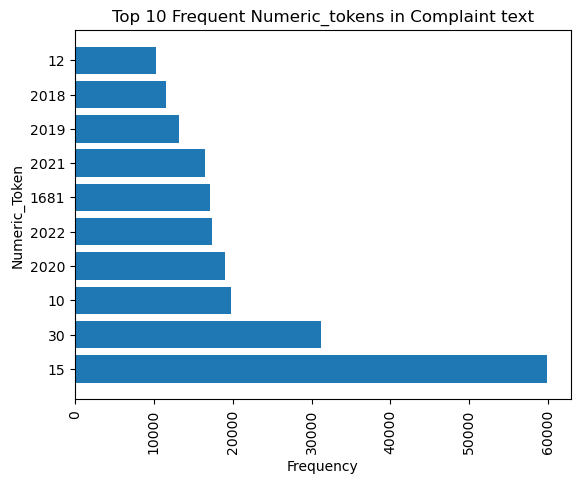

In [128]:
numeric_words = (word_counts1[word_counts1['words'].str.isnumeric()].sort_values('frequency',ascending=False)
 .head(10))

import matplotlib.pyplot as plt

plt.barh(numeric_words.words, numeric_words.frequency)
plt.xticks(rotation=90)
plt.xlabel("Frequency")
plt.ylabel("Numeric_Token")
plt.title("Top 10 Frequent Numeric_tokens in Complaint text")
plt.show()

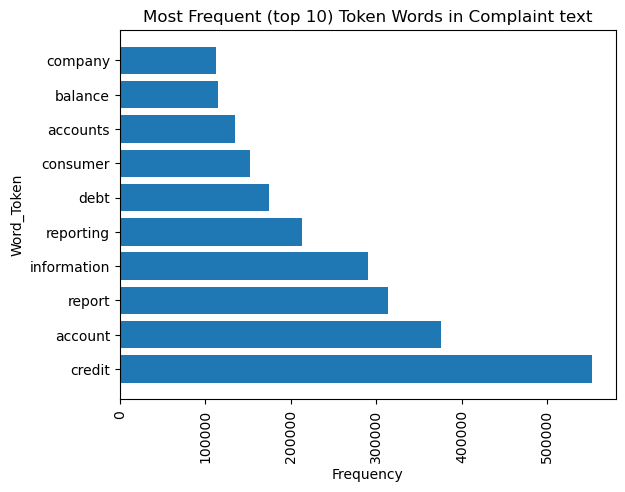

In [129]:
(word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]) #69814 rows × 2 columns. Top two  were XXXX (4146048) and xx (821131)

plt.barh((word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words, (word_counts1[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)
plt.xticks(rotation=90)
plt.xlabel("Frequency")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text")
plt.show()

### next step to find token frequency per category.

In [133]:
reviews["Issue"].value_counts()

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: Issue, dtype: int64

In [184]:
incorrect_info = reviews[reviews["Issue"]=="Incorrect information on your report"]
collect_debt = reviews[reviews["Issue"]=="Attempts to collect debt not owed"]
pay_mortgage = reviews[reviews["Issue"]=="Struggling to pay mortgage"]
comm_tactics = reviews[reviews["Issue"]=="Communication tactics"]
fraud = reviews[reviews["Issue"]=="Fraud or scam"]

In [225]:
vect1 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect_incorrect_info = vect1.fit(incorrect_info['complaint_clean'])
X_train_incorrect_info = vect1.transform(incorrect_info['complaint_clean'])


vocb_incorrect_info = vect1.vocabulary_
vocb_incorrect_info

{'name': 29918,
 'xxxx': 48875,
 'complaint': 11411,
 'made': 27867,
 'error': 17828,
 'neither': 30284,
 'third': 43948,
 'party': 32723,
 'declare': 13874,
 'penalty': 33019,
 'perjury': 33153,
 'alleging': 4843,
 'person': 33274,
 'company': 11318,
 'without': 48444,
 'authorization': 6734,
 'unauthorized': 45607,
 'use': 46727,
 'social': 40831,
 'security': 39533,
 'number': 31003,
 'card': 9371,
 'used': 46732,
 'personal': 33279,
 'identifying': 23123,
 'information': 24511,
 'apply': 5785,
 'goods': 21336,
 'services': 39815,
 'money': 29300,
 'successful': 42316,
 'creating': 12948,
 'accounts': 3449,
 'knowledge': 26480,
 'investigated': 25491,
 'ftc': 20684,
 '15': 395,
 'code': 10809,
 '1681b': 584,
 'permissible': 33195,
 'purposes': 35275,
 'consumer': 12042,
 'reports': 37380,
 'never': 30367,
 'gave': 21008,
 'written': 48718,
 'consent': 11880,
 'report': 37293,
 'anything': 5576,
 'date': 13583,
 'opened': 31782,
 'xx': 48859,
 '2018': 1108,
 'balance': 7134,
 '90': 2

In [226]:
key_sum = len(vocb_incorrect_info.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

Total count of token(words) in the vocabulary: 50395


In [227]:
word_counts_incorrect_info = pd.DataFrame({
    'words': vect1.get_feature_names_out(), #sorted(vocb_dic.keys()) can also give it in the same order
    #becoz the vocb_dic is not in the same order for count(frequency) so we can not use the dic.keys for word to match the grefuency
    'frequency': np.array(X_train_incorrect_info.sum(axis = 0)).flatten()
})


In [228]:
word_counts_incorrect_info.sort_values('frequency', ascending=False) #50395 rows × 2 columns

,words,frequency
48875,xxxx,4286797
48859,xx,756808
12989,credit,576934
3404,account,349326
37293,report,344176
...,...,...
25865,itemsfrom,1
25862,itemsand,1
25860,itemper,1
25859,itemon,1


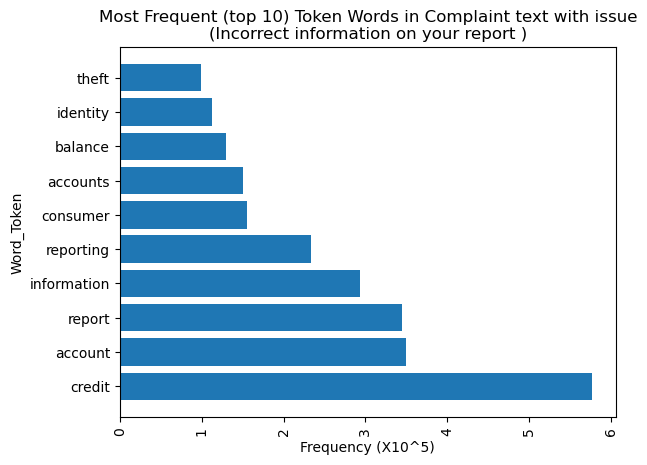

In [229]:
(word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (4286797) and xx (756808)

plt.barh((word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words,
        ((word_counts_incorrect_info[~word_counts_incorrect_info['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Incorrect information on your report )")
plt.show()

### collect_debt

In [230]:
vect2 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect2.fit(collect_debt['complaint_clean'])
X_train_collect_debt = vect2.transform(collect_debt['complaint_clean'])
vocb_collect_debt = vect2.vocabulary_
vocb_collect_debt
key_sum = len(vocb_collect_debt.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_collect_debt = pd.DataFrame({
    'words': vect2.get_feature_names_out(), 
    'frequency': np.array(X_train_collect_debt.sum(axis = 0)).flatten()
})

Total count of token(words) in the vocabulary: 37745


In [222]:
(word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (669978) and xx (156653)

,words,frequency
36976,xxxx,669978
36959,xx,156653
9804,credit,140754
10352,debt,129519
2398,account,105337
...,...,...
18485,instalments,1
18482,installmet,1
18476,installement,1
18472,instalationn,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\1351652150.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_collect_debt[~word_counts1['words'].str.isnumeric()].


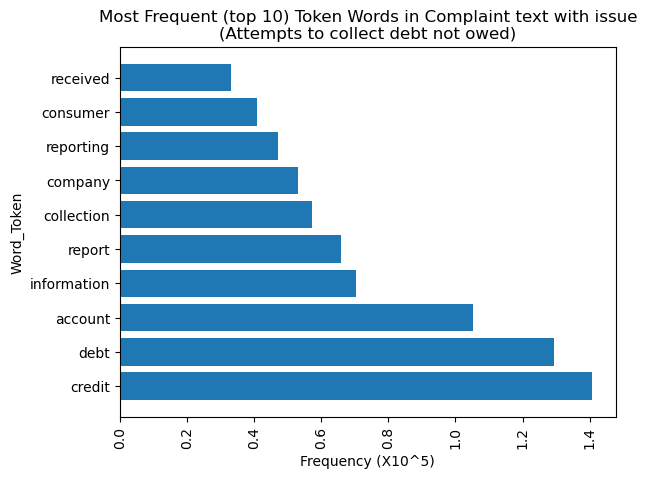

In [232]:
(word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #48883 rows × 2 columns. Top two  were XXXX (669978) and xx (156653)

plt.barh((word_counts_collect_debt[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words, 
         ((word_counts_collect_debt[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Attempts to collect debt not owed)")
plt.show()

## pay_mortgage 

In [233]:
vect3 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect3.fit(pay_mortgage['complaint_clean'])
X_train_pay_mortgage = vect3.transform(pay_mortgage['complaint_clean'])
vocb_pay_mortgage = vect3.vocabulary_
vocb_pay_mortgage
key_sum = len(vocb_pay_mortgage.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_pay_mortagage = pd.DataFrame({
    'words': vect3.get_feature_names_out(), 
    'frequency': np.array(X_train_pay_mortgage.sum(axis = 0)).flatten()
})
word_counts_pay_mortagage

Total count of token(words) in the vocabulary: 30184


,words,frequency
0,00,1320
1,01,31
2,010,4
3,01093,1
4,015,2
...,...,...
30179,zones,2
30180,zoning,2
30181,zoo,1
30182,zoom,4


C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\1040457291.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.barh((word_counts_pay_mortagage[~word_counts_collect_debt['words'].str.isnumeric()].
C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\1040457291.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_pay_mortagage[~word_counts1['words'].str.isnumeric()].


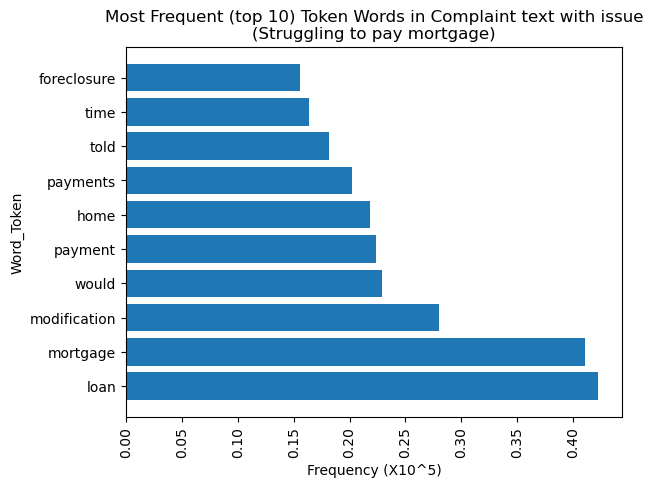

In [234]:
(word_counts_pay_mortagage[~word_counts_pay_mortagage['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #29300 rows × 2 columns. Top two  were XXXX (264660) and xx (104588)

plt.barh((word_counts_pay_mortagage[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words, 
         ((word_counts_pay_mortagage[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Struggling to pay mortgage)")
plt.show()

# Fraud

In [ ]:
# fraud = reviews[reviews["Issue"]=="Fraud or scam"]

In [240]:
vect4 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect4.fit(fraud['complaint_clean'])
X_train_fraud = vect4.transform(fraud['complaint_clean'])
vocb_fraud = vect4.vocabulary_
vocb_fraud
key_sum = len(vocb_fraud.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_fraud = pd.DataFrame({
    'words': vect4.get_feature_names_out(), 
    'frequency': np.array(X_train_fraud.sum(axis = 0)).flatten()
})
word_counts_fraud

Total count of token(words) in the vocabulary: 22257


,words,frequency
0,00,743
1,01,3
2,016,1
3,017,1
4,02,5
...,...,...
22252,zones,2
22253,zoom,9
22254,zpass,1
22255,zt,1


In [242]:
(word_counts_fraud[~word_counts_fraud['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #21831 rows × 2 columns. Top two  were XXXX (168616) and xx (40720)

,words,frequency
21872,xxxx,168616
21865,xx,40720
925,account,27603
12590,money,21547
2485,bank,20352
...,...,...
14789,predoctoral,1
14790,predominantly,1
14791,preempt,1
14793,preety,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\2812912612.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.barh((word_counts_fraud[~word_counts_collect_debt['words'].str.isnumeric()].
C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\2812912612.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_fraud[~word_counts1['words'].str.isnumeric()].


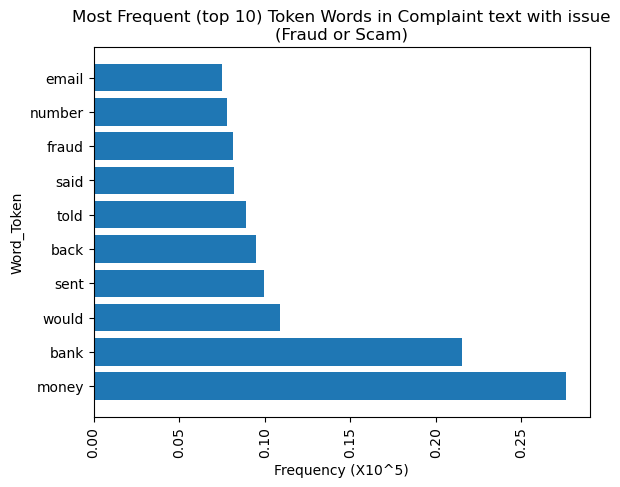

In [243]:
plt.barh((word_counts_fraud[~word_counts_collect_debt['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words, 
         ((word_counts_fraud[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Fraud or Scam)")
plt.show()

# communication

In [ ]:
# comm_tactics = reviews[reviews["Issue"]=="Communication tactics"]

In [244]:
vect5 = CountVectorizer(stop_words=stopwords.words('english')) #doing countvectorizer after removing stop words
    
vect5.fit(comm_tactics['complaint_clean'])
X_train_comm_tactics = vect5.transform(comm_tactics['complaint_clean'])
vocb_comm_tactics = vect5.vocabulary_
vocb_comm_tactics
key_sum = len(vocb_fraud.keys())
print("Total count of token(words) in the vocabulary:", key_sum)

word_counts_comm_tactics = pd.DataFrame({
    'words': vect5.get_feature_names_out(), 
    'frequency': np.array(X_train_comm_tactics.sum(axis = 0)).flatten()
})

word_counts_comm_tactics

Total count of token(words) in the vocabulary: 22257


,words,frequency
0,00,96
1,01,2
2,02,1
3,03,3
4,04,3
...,...,...
20498,zoom,1
20499,zooms,1
20500,zuntafi,1
20501,zwicker,36


In [246]:
(word_counts_comm_tactics[~word_counts_comm_tactics['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)) #20029 rows × 2 columns. Top two  were XXXX (128056) and xx (34286)

,words,frequency
20172,xxxx,128056
20168,xx,34286
5241,debt,23775
3230,call,23673
13443,phone,17707
...,...,...
10041,investimate,1
10042,investing,1
10047,invincible,1
10048,inviolation,1


C:\Users\upadh\AppData\Local\Temp\ipykernel_39528\4149510228.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((word_counts_comm_tactics[~word_counts1['words'].str.isnumeric()].


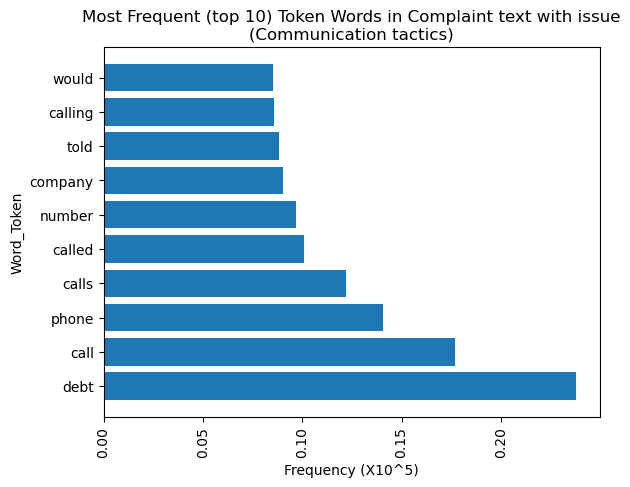

In [247]:
plt.barh((word_counts_comm_tactics[~word_counts_comm_tactics['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).words, 
         ((word_counts_comm_tactics[~word_counts1['words'].str.isnumeric()].
 sort_values('frequency',ascending=False)
.iloc[2:12]).frequency)/100000)
plt.xticks(rotation=90)
plt.xlabel("Frequency (X10^5)")
plt.ylabel("Word_Token")
plt.title("Most Frequent (top 10) Token Words in Complaint text with issue\n(Communication tactics)")
plt.show()

In [ ]:
##Now, let's fit a MultinomialNB model to our word count vectors.

##Word_Vectors_for_Classification
vectorizing the complete complaint text
First, let's create an initial vector of zeros. Do this using the numpy zeros function. Make sure that the result will have the same shape as the word vectors from the matrix.

We'll also need to count the number of words in the review for which we have an embedding. We'll initialize a counter variable at 0.

In [130]:
# embedding = np.zeros(shape = (word_vectors.shape[1],))
# count = 0